## In this project I've implemented basic neural network using mainly NumPy. Results turns out to be quite satisfying. It was great coding and visualisation training.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ing_theme_matplotlib import mpl_style
mpl_style("dark")

In [2]:
def one_hot(categories):
    unique_categories = np.unique(categories)
    one_hot_encoding = np.zeros((len(categories), len(unique_categories)))

    for i, category in enumerate(categories):
        index = np.where(unique_categories == category)[0][0]
        one_hot_encoding[i, index] = 1

    return(one_hot_encoding)

In [3]:
def read(path):
    D = pd.read_csv(path)
    x = np.array(D.x)
    y = np.array(D.y)
    if("c" in D.columns):
        c = np.array(D.c)
        return np.array((x,y)).transpose(),one_hot(c).astype(int)
    else: 
        return np.row_stack(x), np.row_stack(y)

In [4]:
def F_score(Y,y_pred):
    classes = np.argmax(y_pred, axis = 1)
    y_pred = np.zeros(y.shape)
    y_pred[np.arange(len(y_pred)),classes] = 1
    y_pred = y_pred.astype(int).transpose()
    Y = Y.astype(int).transpose()
    result = np.zeros(len(Y))
    for i in range(len(Y)):
        pred_positives = np.count_nonzero(y_pred[i])
        positives = np.count_nonzero(Y[i])
        tp = np.count_nonzero(y_pred[i] & Y[i])
        if tp == 0:
            result[i]= 0
        else:
            result[i]= 2/(pred_positives/tp + positives/tp)
    return result

In [5]:
def MSE(y, Y):
    return ((Y-y)*(Y-y)).sum()/len(Y)

In [6]:
def Softmax(x):
    s = np.exp(x)
    p = np.sum(s,axis = 1, keepdims=True)
    return s/p

In [7]:
def Relu(x):
    return np.where(x>0, x, 0)

In [8]:
def Relu_der(x):
    return np.where(x>0, 1, 0)

In [9]:
import warnings
def Sigmoid(x):
    warnings.filterwarnings('ignore')
    return 1/(1+np.exp(-x))

In [10]:
def Sigmoid_der(x):
    s = Sigmoid(x)
    return s*(1-s)

In [11]:
def Id(x):
    return x

In [12]:
def Id_der(x):
    return np.ones(x.shape)

In [13]:
def Tanh(x):
    return np.tanh(x)

In [14]:
def Tanh_der(x): 
    return 1 - np.square(np.tanh(x))

In [15]:
class NeuralNetwork(object):
    def __init__(self,layers,activ_fun=Sigmoid, activ_fun_der=Sigmoid_der):
        outs = layers[1:]
        ins = layers[:-1]
        self.w = [np.random.normal(0,np.sqrt(2/(insi+outi)),size = (insi,outi)) for (insi,outi) in zip(ins,outs)]
        self.b = [np.zeros(outi) for outi in outs]
        self.activ_fun = activ_fun
        self.activ_fun_der = activ_fun_der
        # zakładam, że jednowymiarowy output to regresja pozostałe przypadki to klasyfikacja. Tylko w regresji się denormalizuje output na wyjściu
        if layers[-1] == 1:
            self.measure = MSE
            self.end_fun = self.denormalize
        else:
            self.measure = F_score 
            self.end_fun = Softmax
        #funkcja aktywacji z kombinacji liniowej
        self.a = [None]*len(self.w)
        #kombinacje liniowe w itym neuronie 
        self.z = [None]*len(self.w)
        self.meanx = 0
        self.meany = 0
        self.stdx = 1
        self.stdy = 1
        #Velocity do zapamiętania momentów
        self.Vb = [np.zeros(bi.shape) for bi in self.b]
        self.Vw = [np.zeros(wi.shape) for wi in self.w]
        #Średnie do zapamiętania RMSProp
        self.Mb = [np.zeros(bi.shape) for bi in self.b]
        self.Mw = [np.zeros(wi.shape) for wi in self.w]

    def set_normals(self,x,y):
        self.meanx = np.mean(x)
        self.stdx = np.std(x)
        self.meany = np.mean(y)
        self.stdy = np.std(y)
        
    def normalize(self,x):
        #Powinno być inaczej ale nasze x1 i x2 są losowane z tego samego rozkładu więc działa tak samo
        return (x-self.meanx)/self.stdx
    
    def denormalize(self,y_pred):
        return y_pred*self.stdy +self.meany

    
    def fit(self,x):
        #x jako pierwsza warstwa, wiersz to jedna obserwacja
        l = self.normalize(x)
        self.z[0] = l
        #rekurencyjna pętla przechodząca po warstwach
        for i in range(len(self.w)-1):
            self.a[i]=l
            l = l@self.w[i]+self.b[i]
            self.z[i+1]= l
            l = self.activ_fun(l)
        self.a[-1]=l

        ans = self.end_fun(l@self.w[-1]+self.b[-1])
        return ans
    
    def gradient(self,x,y):
        n = len(self.w)
        gb = [np.zeros(b.shape) for b in self.b]
        gw = [np.zeros(w.shape) for w in self.w]
        #fit zapamietuje wartosci wchodzace i te po kombinacjach liniowych
        y_pred = self.fit(x)
        delta = (y_pred-y)/len(x)
        # implementacja backpropagacji
        for i in range(1,n+1):
                gb[-i] = np.sum(delta,axis = 0)
                gw[-i] = (self.a[-i].transpose())@delta
                delta = (delta@(self.w[-i].transpose()))*(self.activ_fun_der(self.z[-i]))
        return gb, gw
    
    def train(self,x,y,batchsize, learn_ratio, epochs,  shuffle = True, method = "Adam"):
        n = len(x)
        self.set_normals(x,y)
        measure= [None]*epochs
        #SGD domyślne
        direction_fun = self.Adam
        if method == "RMSProp":
            direction_fun =  self.RMSProp
        elif method == "Momentum":
            direction_fun =  self.Momentum
        elif method == "SGD":
            method = self.SGD
        for i in range(epochs):
            indexes = list(range(n))
            if shuffle:
                np.random.shuffle(indexes)
            for k in range(0,n,batchsize):
                #bierzemy batchsize wybranych indeksow
                use = indexes[k:k+batchsize]
                #liczymy gradienty dla tych obserwacji i aktualnych parametrów
                Gb, Gw = self.gradient(x[use],y[use])
                Gb, Gw = direction_fun(Gb,Gw)
                #aktualizacja parametrów
                self.w = [wi- learn_ratio*gi for (wi,gi) in zip(self.w,Gw)]
                self.b = [bi- learn_ratio*gi for (bi,gi) in zip(self.b,Gb)]
            #zapis mse po użyciu pełnego epoch danych
            measure[i] = np.mean(self.measure(y,self.fit(x)))
        return np.array(measure).transpose()
    
    # różne funkcje wyznaczania kierunku optymalizacji
    def Momentum(self,Gb,Gw, beta = 0.9):
        self.Vb = [beta*vbi + gbi for (vbi,gbi) in zip(self.Vb,Gb)]
        self.Vw = [beta*vwi + gwi for (vwi,gwi) in zip(self.Vw,Gw)]
        return self.Vb, self.Vw

    def RMSProp(self,Gb,Gw,beta = 0.9):
        self.Mb = [beta*mbi + (1-beta)*np.square(gbi) for (mbi,gbi) in zip(self.Mb,Gb)]
        self.Mw = [beta*mwi + (1-beta)*np.square(gwi) for (mwi,gwi) in zip(self.Mw,Gw)]
        #aktualizacja parametrów
        Gw = [np.divide(gwi,np.sqrt(mwi)+0.00001) for (mwi,gwi) in zip(self.Mw,Gw)]
        Gb = [np.divide(gbi,np.sqrt(mbi)+0.00001) for (mbi,gbi) in zip(self.Mb,Gb)]
        return Gb,Gw
    
    def SGD(self, Gb,Gw):
        return Gb,Gw
    
    def Adam(self, Gb,Gw):
        beta1 = 0.9
        beta2= 0.999
        self.Vb = [beta1*vbi + (1-beta1)*gbi for (vbi,gbi) in zip(self.Vb,Gb)]
        self.Vw = [beta1*vwi + (1-beta1)*gwi for (vwi,gwi) in zip(self.Vw,Gw)]
        self.Mb = [beta2*mbi + (1-beta2)*np.square(gbi) for (mbi,gbi) in zip(self.Mb,Gb)]
        self.Mw = [beta2*mwi + (1-beta2)*np.square(gwi) for (mwi,gwi) in zip(self.Mw,Gw)]
        Gw = [np.divide(vwi/(1-beta1),np.sqrt(mwi/(1-beta2))+0.00001) for (mwi,vwi) in zip(self.Mw,self.Vw)]
        Gb = [np.divide(vbi/(1-beta1),np.sqrt(mbi/(1-beta2))+0.00001) for (mbi,vbi) in zip(self.Mb,self.Vb)]
        return Gb,Gw

In [16]:
import copy
# Funkcja stworzona do porównywania różnych funkcji aktywacji
def compare(x,y,batchsize, rate, epochs, layers, times = 1,shuffle = True):
    sigmo_measure = np.zeros(epochs)
    linear_measure = np.zeros(epochs)
    tanh_measure = np.zeros(epochs)
    relu_measure = np.zeros(epochs)
    for i in range(times):
        model_sigmo = NeuralNetwork(layers)
        model_linear = NeuralNetwork(layers,Id,Id_der)
        model_tanh = NeuralNetwork(layers,Tanh, Tanh_der)
        model_relu = NeuralNetwork(layers, Relu,Relu_der)
        w = copy.deepcopy(model_sigmo.w)
        b = copy.deepcopy(model_sigmo.b)
        model_linear.w = w
        model_linear.b = b
        model_tanh.w = w
        model_tanh.b = b
        model_relu.w = w
        model_relu.b = b
        sigmo_measure += model_sigmo.train(x,y,batchsize,rate,epochs,method="RMSProp", shuffle=shuffle)/times
        linear_measure += model_linear.train(x,y,batchsize,rate,epochs,method="RMSProp", shuffle=shuffle)/times
        tanh_measure += model_tanh.train(x,y,batchsize,rate,epochs,method="RMSProp", shuffle=shuffle)/times
        relu_measure += model_relu.train(x,y,batchsize,rate,epochs,method="RMSProp", shuffle=shuffle)/times

    print("Końcowe uśredniona miara dla sigmoidy:", sigmo_measure[-1])
    print("Końcowe uśredniona miara dla liniowej:", linear_measure[-1])
    print("Końcowe uśredniona miara dla tanh:", tanh_measure[-1])
    print("Końcowe uśredniona miara dla ReLU:", relu_measure[-1])
    a = list(range(epochs))
    plt.scatter(a, sigmo_measure[a], label = "sigmoida")
    plt.scatter(a, linear_measure[a], label = "liniowa")
    plt.scatter(a, tanh_measure[a], label = "tanh")
    plt.scatter(a, relu_measure[a], label = "ReLU")
    plt.legend()

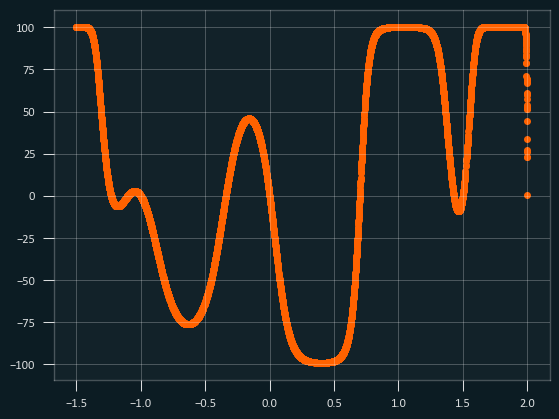

In [17]:
x,y = read("regression/multimodal-large-training.csv")
plt.scatter(x,y)
plt.show()

Końcowe uśredniona miara dla sigmoidy: 504.4216855614256
Końcowe uśredniona miara dla liniowej: 4403.188052886693
Końcowe uśredniona miara dla tanh: 340.44108087746594
Końcowe uśredniona miara dla ReLU: 1830.8107265575743


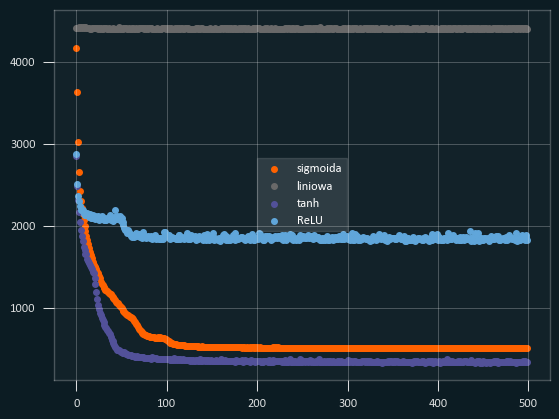

In [179]:
compare(x,y,100,0.01,500,[1,5,1],times=5)

Końcowe uśredniona miara dla sigmoidy: 601.1570534163833
Końcowe uśredniona miara dla liniowej: 4398.910478437121
Końcowe uśredniona miara dla tanh: 543.4364286288949
Końcowe uśredniona miara dla ReLU: 1287.0459128851426


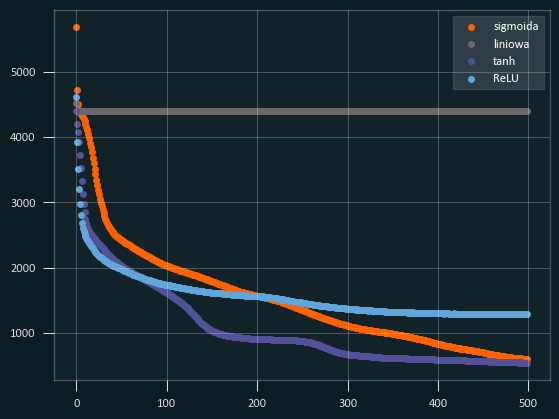

In [180]:
compare(x,y,100,0.001,500,[1,10,1],times=5)

Końcowe uśredniona miara dla sigmoidy: 779.8535452784604
Końcowe uśredniona miara dla liniowej: 4398.919836349717
Końcowe uśredniona miara dla tanh: 239.99681873496792
Końcowe uśredniona miara dla ReLU: 1960.7691673114596


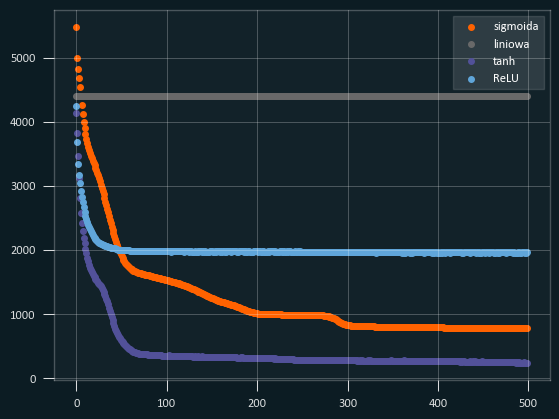

In [181]:
compare(x,y,100,0.001,500,[1,5,5,1],times=5)

8.96644385581858


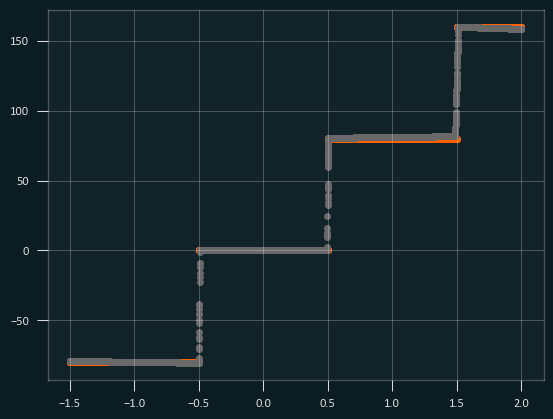

In [40]:
x,y = read("regression/steps-large-training.csv")
model = NeuralNetwork([1,10,10,1],Relu,Relu_der)
print(model.train(x,y,100,0.01,1000,"RMSProp")[-1])
y_pred = model.fit(x)
plt.scatter(x,y)
plt.scatter(x,y_pred)

2.898507980157187


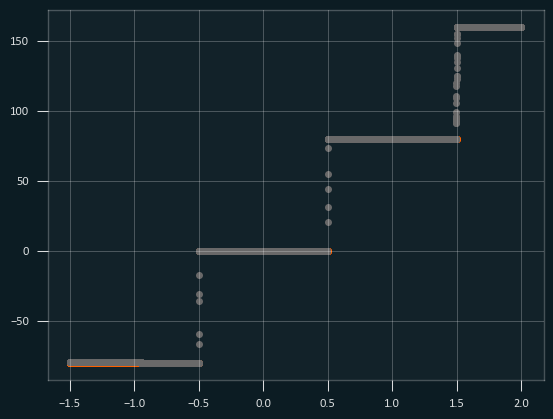

In [44]:
x,y = read("regression/steps-large-training.csv")
print(model.train(x,y,100,0.001,5000,"RMSProp")[-1])
y_pred = model.fit(x)
plt.scatter(x,y)
plt.scatter(x,y_pred)

Miara dla testu: 2.208856546775992


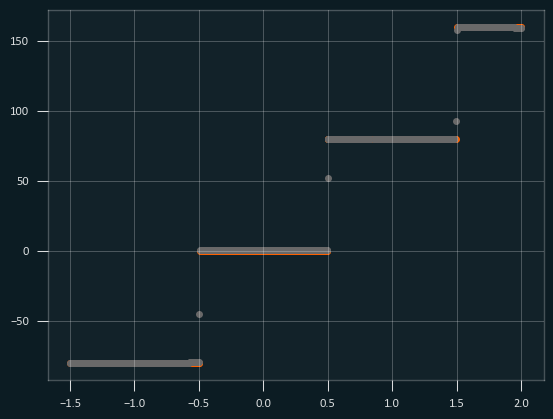

In [43]:
x,y = read("regression/steps-large-test.csv")
y_pred = model.fit(x)
print("Miara dla testu:", model.measure(y_pred,y))
plt.scatter(x,y)
plt.scatter(x,y_pred)

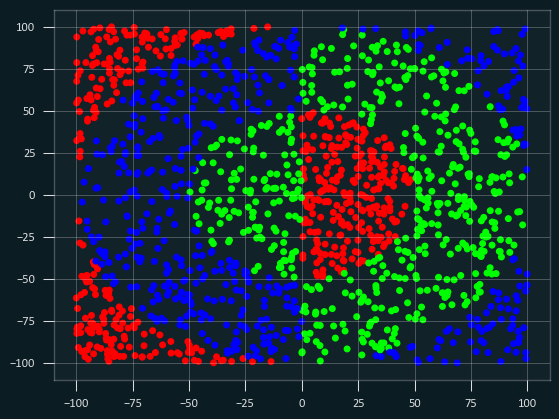

In [145]:
x,y = read("classification/rings3-regular-training.csv")
plt.scatter(x.transpose()[0],x.transpose()[1], c= y)
plt.show()

0.987991766588126


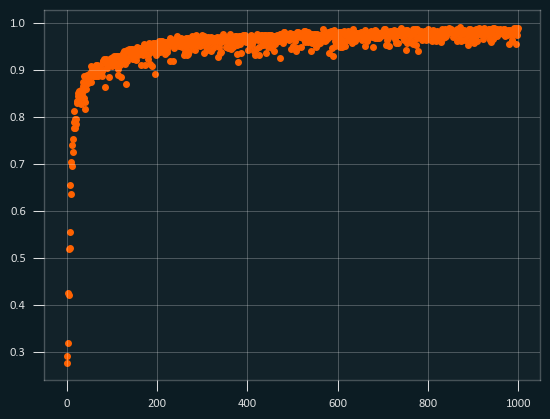

In [167]:
x,y = read("classification/rings5-regular-training.csv")
model2 = NeuralNetwork([2,10,10,5], Tanh, Tanh_der)
measure = model2.train(x,y,100,0.01,1000, method = "RMSProp")
print(measure[-1])
plt.scatter(list (range(1000)), measure)

In [169]:
x,y = read("classification/rings5-regular-training.csv")
measure = model2.train(x,y,100,0.001,5000,method = "RMSProp")
print(measure[-1])
x,y = read("classification/rings5-regular-test.csv")
y_pred = model2.fit(x)
np.mean(model2.measure(y,y_pred))

0.9991999967999872


0.9775238333205252

0.9826565703957447


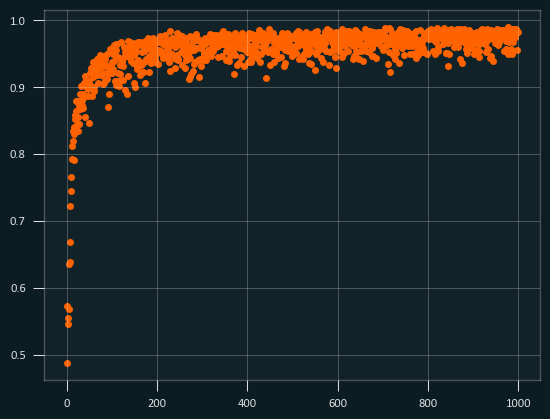

In [172]:
x,y = read("classification/rings3-regular-training.csv")
model3 = NeuralNetwork([2,10,10,3], Tanh, Tanh_der)
measure = model3.train(x,y,100,0.01,1000, method = "RMSProp")
print(measure[-1])
plt.scatter(list (range(1000)), measure)

In [174]:
x,y = read("classification/rings3-regular-training.csv")
measure = model3.train(x,y,100,0.001,5000,method = "RMSProp")
print(measure[-1])
x,y = read("classification/rings3-regular-test.csv")
y_pred = model3.fit(x)
np.mean(model3.measure(y,y_pred))

0.9966639812945196


0.9757641229539921